<a href="https://colab.research.google.com/github/ssyss-513/MyColab/blob/main/COMP5434/5434_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
"""
Earthquake Alert Level Prediction
Full 5-Step Analytical Process: Acquire, Prepare, Analyze, Report, Act
Author: ChatGPT (Custom Implementation)
"""

# ==============================
# Step 1: Acquire 数据获取
# ==============================
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print("✅ Data Loaded Successfully!")
print(df.head(), "\n")
print(df.info(), "\n")
print(df_test.head(), "\n")
print(df_test.info(), "\n")

✅ Data Loaded Successfully!
   id  magnitude  depth  cdi  mmi  sig  label
0   1        6.9     25    4    4  -33      0
1   2        7.0    579    3    3  -13      0
2   3        6.6    624    0    2  -98      0
3   4        6.8    630    1    3  -57      0
4   5        6.7     20    7    6   29      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         909 non-null    int64  
 1   magnitude  909 non-null    float64
 2   depth      909 non-null    int64  
 3   cdi        909 non-null    int64  
 4   mmi        909 non-null    int64  
 5   sig        909 non-null    int64  
 6   label      909 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 49.8 KB
None 

       id  magnitude  depth  cdi  mmi  sig
0  100001        7.0     14    8    7    0
1  100002        7.3     37    5    5   65
2  100003        7.0    660    4    3  -13


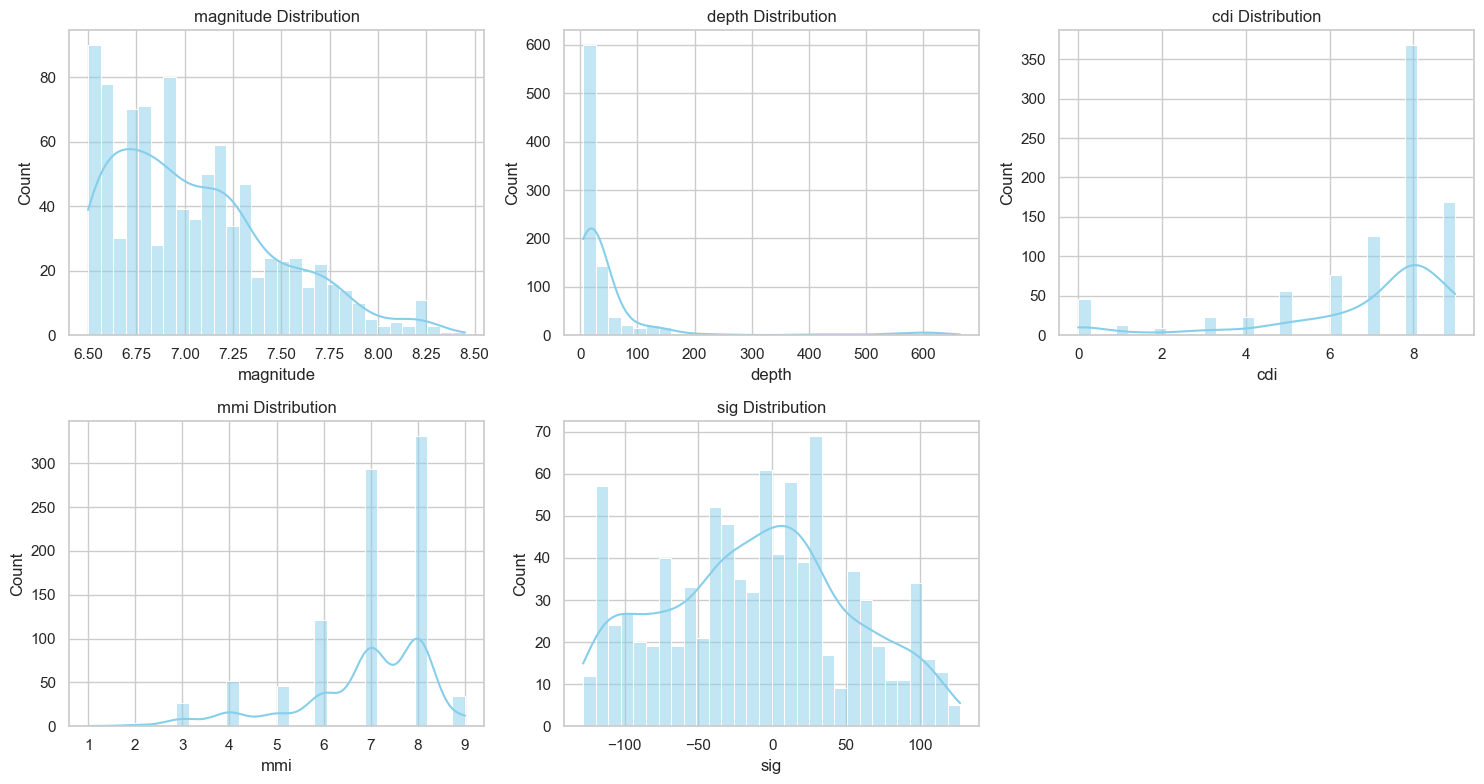

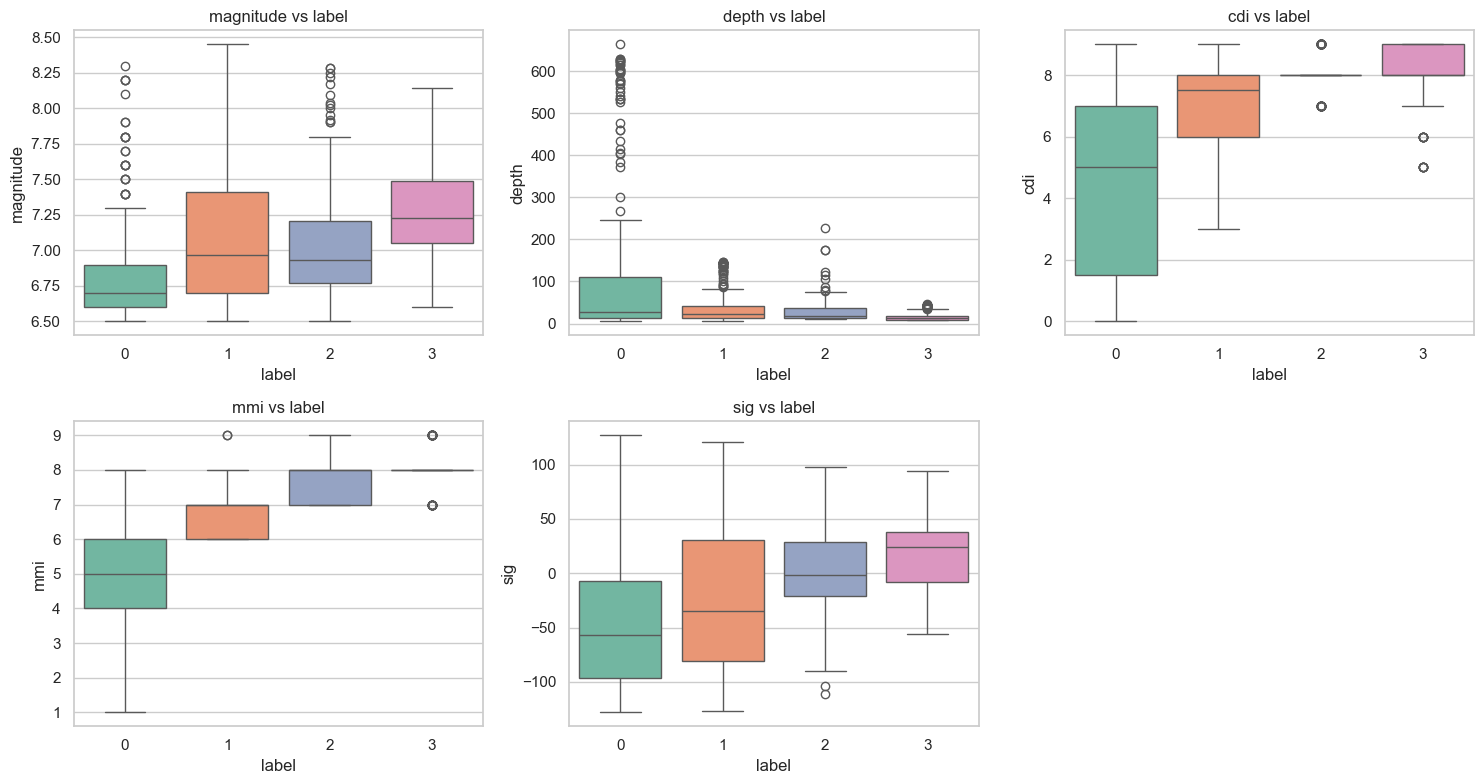

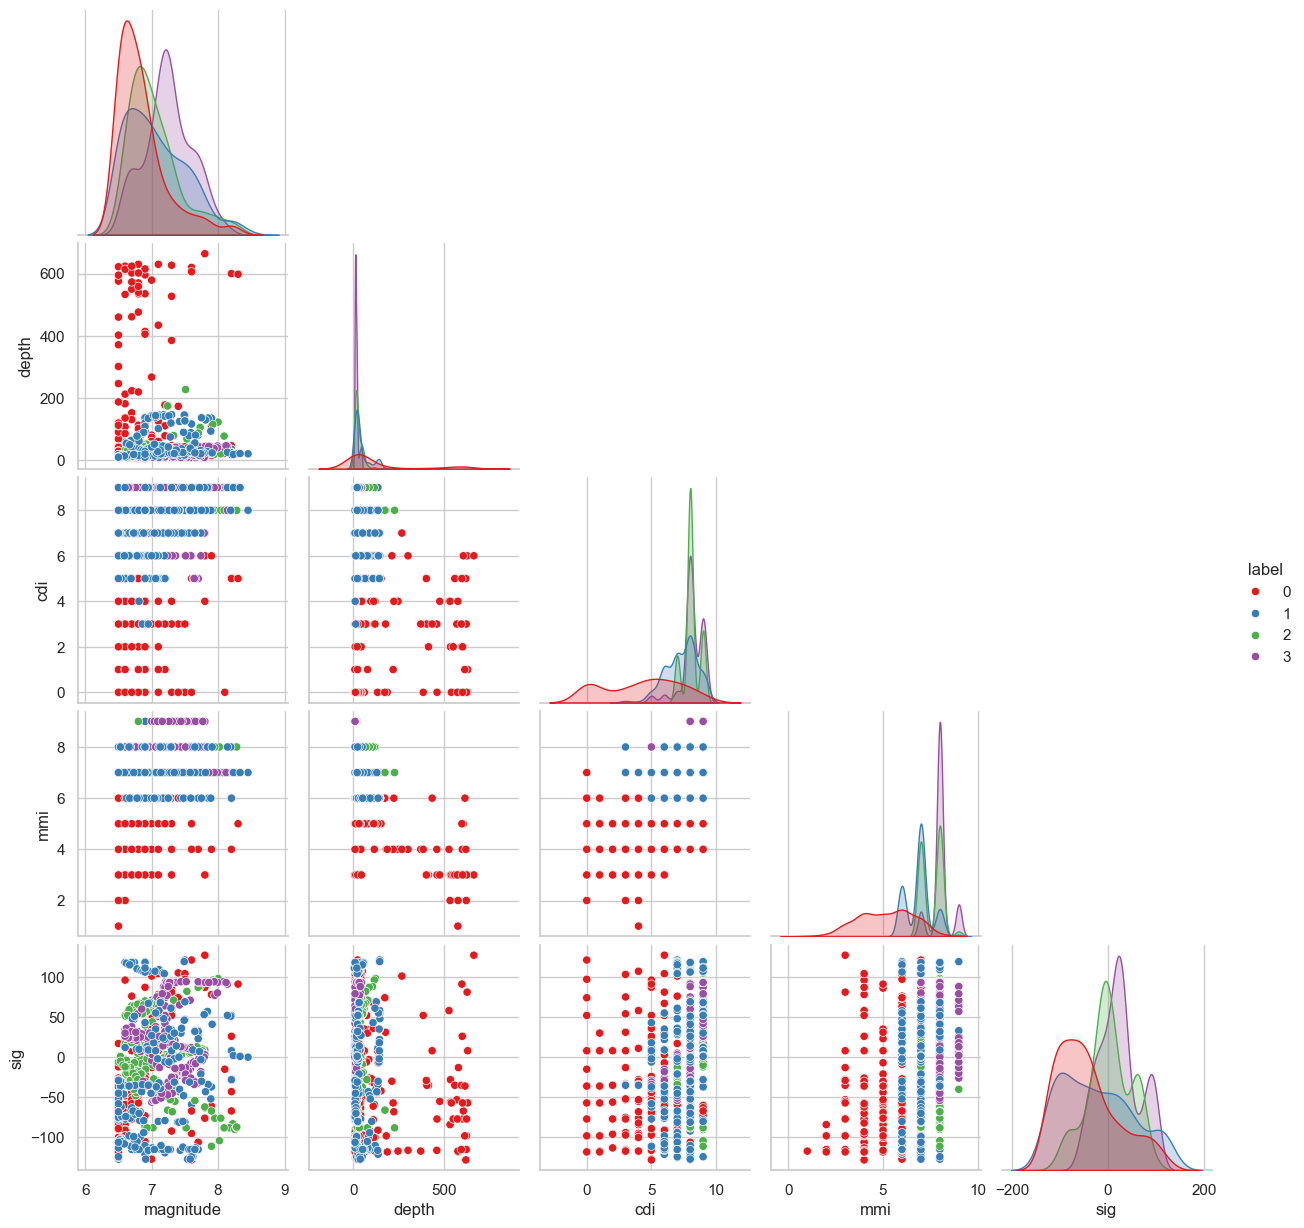

In [10]:
# ===== 导入库 =====
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set_theme(style="whitegrid")

# 特征列表（排除 id 和 label）
features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

# 1️⃣ 每列特征的直方图
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 2️⃣ 每列特征与 label 的箱型图
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='label', y=col, data=df, hue='label', palette='Set2', legend=False)
    plt.title(f'{col} vs label')
plt.tight_layout()
plt.show()

# 3️⃣ 特征与 label 的散点图矩阵（pairplot）
sns.pairplot(df, vars=features, hue='label', palette='Set1', corner=True)
plt.show()


In [11]:
from scipy import stats
# 删除异常值
# 假设你的数据集是 df，且特征列如下：
feature_cols = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

# 计算 Z-score
z_scores = np.abs(stats.zscore(df[feature_cols]))

# 设置阈值
threshold = 3

# 找出异常值（返回布尔矩阵）
outliers = (z_scores > threshold)

# 统计每列异常值数量
outlier_counts = np.sum(outliers, axis=0)
print("每个特征的异常值数量：")
for col, count in zip(feature_cols, outlier_counts):
    print(f"{col}: {count}")

# 删除包含异常值的样本（如果某行任意列是异常值）
df_cleaned = df[(z_scores < threshold).all(axis=1)]

print(f"\n原始样本数: {len(df)}, 清洗后样本数: {len(df_cleaned)}")
print(f"共删除 {len(df) - len(df_cleaned)} 个异常样本")

# 查看清洗后数据基本情况
print("\n✅ 清洗后数据预览：")
print(df_cleaned.head())

每个特征的异常值数量：
magnitude: 2
depth: 36
cdi: 0
mmi: 5
sig: 0

原始样本数: 909, 清洗后样本数: 871
共删除 38 个异常样本

✅ 清洗后数据预览：
   id  magnitude  depth  cdi  mmi  sig  label
0   1        6.9     25    4    4  -33      0
4   5        6.7     20    7    6   29      0
5   6        7.6     26    9    8    7      1
6   7        6.9     10    9    9  119      1
7   8        6.5     10    7    7  -12      0


each feature relationship VS label

In [6]:
corr = df.corr()['label'].abs().sort_values(ascending=False)
print(corr)

label        1.000000
mmi          0.749104
cdi          0.610180
id           0.430429
sig          0.395159
depth        0.345300
magnitude    0.315328
Name: label, dtype: float64


In [12]:
# ==============================
# Step 2: Prepare 数据准备
# ==============================
from sklearn.preprocessing import StandardScaler

# 1. 查看异常值数量（可选，用于定位问题）
print(f"depth 中小于 -1 的值数量：{(df_cleaned['depth'] < -1).sum()}")
# Step 1: 对 depth 先对数压缩
df_cleaned['depth'] = np.log1p(df_cleaned['depth'])

# Step 2: 再标准化 depth 和 sig
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cleaned[['depth', 'sig']] = scaler.fit_transform(df_cleaned[['depth', 'sig']])

# 构造组合特征 worse relationship

# df_cleaned['mag_depth'] = df_cleaned['magnitude'] * df_cleaned['depth']  # magnitude × depth
# df_cleaned['cdi_mmi'] = df_cleaned['cdi'] + df_cleaned['mmi']          # cdi + mmi

# 删除无关列
X = df_cleaned.drop(columns=["id", "label"]).values
X_test = df_test.drop(columns=["id"]).values
y = df_cleaned["label"].values


# 手动划分训练集(70%)、验证集(10%)、测试集(20%)
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

n_train = int(0.7 * len(X))
n_valid = int(0.1 * len(X))

train_idx = indices[:n_train]
valid_idx = indices[n_train:n_train + n_valid]
test_idx  = indices[n_train + n_valid:]

X_train, X_valid, X_test = X[train_idx], X[valid_idx], X[test_idx]
y_train, y_valid, y_test = y[train_idx], y[valid_idx], y[test_idx]



print("✅ Data prepared: train/valid/test =", len(X_train), "/", len(X_valid), "/", len(X_test))


depth 中小于 -1 的值数量：0
✅ Data prepared: train/valid/test = 609 / 87 / 175


/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_22461/1630853520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['depth'] = np.log1p(df_cleaned['depth'])
/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_22461/1630853520.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[['depth', 'sig']] = scaler.fit_transform(df_cleaned[['depth', 'sig']])


Text(0, 0.5, 'Count')

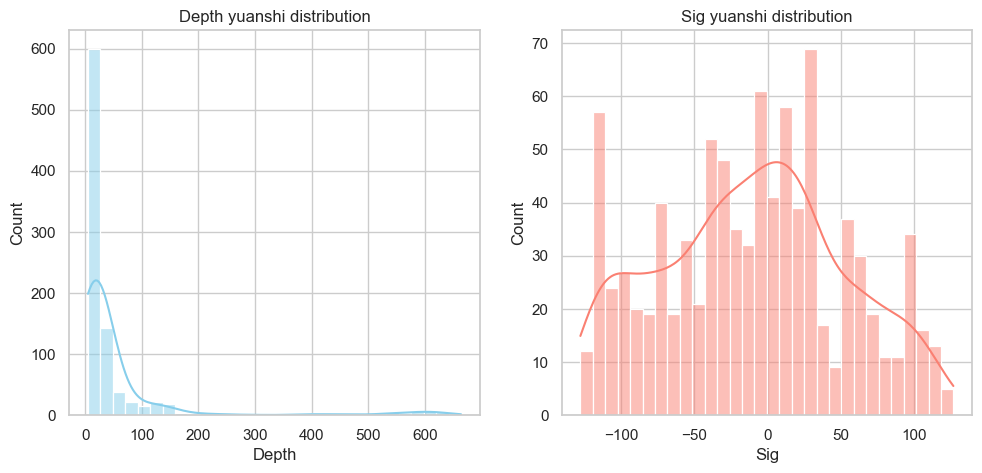

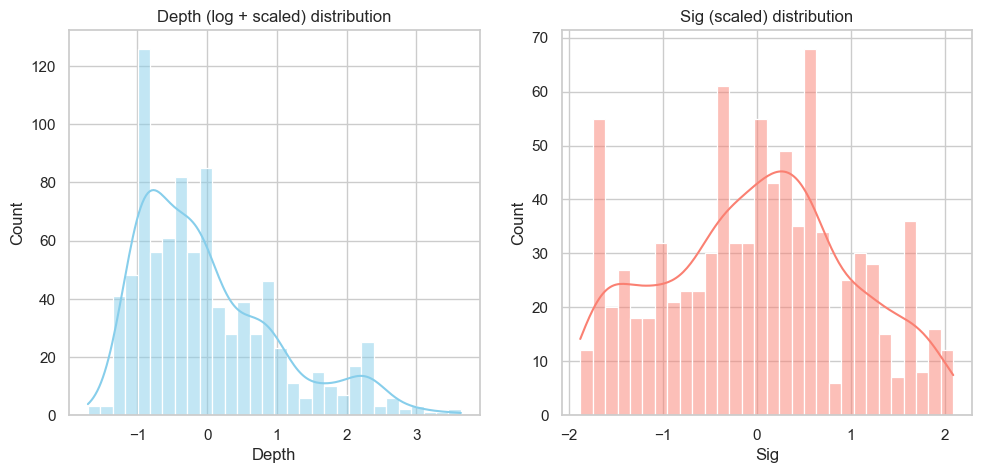

In [17]:
plt.figure(figsize=(18,5))

# 1️⃣ depth 分布
plt.subplot(1,3,1)
sns.histplot(df['depth'], kde=True, bins=30, color='skyblue')
plt.title('Depth yuanshi distribution')
plt.xlabel('Depth')
plt.ylabel('Count')

# 2️⃣ sig 分布
plt.subplot(1,3,2)
sns.histplot(df['sig'], kde=True, bins=30, color='salmon')
plt.title('Sig yuanshi distribution')
plt.xlabel('Sig')
plt.ylabel('Count')


plt.figure(figsize=(18,5))

# 1️⃣ depth 分布
plt.subplot(1,3,1)
sns.histplot(df_cleaned['depth'], kde=True, bins=30, color='skyblue')
plt.title('Depth (log + scaled) distribution')
plt.xlabel('Depth')
plt.ylabel('Count')

# 2️⃣ sig 分布
plt.subplot(1,3,2)
sns.histplot(df_cleaned['sig'], kde=True, bins=30, color='salmon')
plt.title('Sig (scaled) distribution')
plt.xlabel('Sig')
plt.ylabel('Count')

In [ ]:
# from sklearn.decomposition import PCA
# # ===== PCA 降维 =====
# # n_components 可以根据经验选取，比如 95% 方差解释率
# pca = PCA(n_components=0.95)  # 保留95%方差
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

class CustomKNN:
    def __init__(self, k=7, feature_weights=None, distance_weighted=True):
        self.k = k
        self.feature_weights = feature_weights
        self.distance_weighted = distance_weighted

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        w = self.feature_weights if self.feature_weights is not None else np.ones(self.X_train.shape[1])

        # 广播计算加权曼哈顿距离
        # shape: (n_test, n_train, n_features)
        diff = np.abs(self.X_train[None, :, :] - X[:, None, :]) * w
        dist_matrix = np.sum(diff, axis=2)  # shape: (n_test, n_train)

        # 找出每个测试样本最近的 k 个邻居
        nearest_idx = np.argsort(dist_matrix, axis=1)[:, :self.k]
        nearest_labels = self.y_train[nearest_idx]
        nearest_dist = np.take_along_axis(dist_matrix, nearest_idx, axis=1)

        preds = []
        for labels_row, dist_row in zip(nearest_labels, nearest_dist):
            if self.distance_weighted:
                weights = 1 / (dist_row + 1.0)
                scores = {}
                for lbl, wt in zip(labels_row, weights):
                    scores[lbl] = scores.get(lbl, 0) + wt
                preds.append(max(scores, key=scores.get))
            else:
                vals, counts = np.unique(labels_row, return_counts=True)
                preds.append(vals[np.argmax(counts)])
        return np.array(preds)


def find_best_k(X, y, k_candidates=None, feature_weights=None, distance_weighted=True, cv=5):
    if k_candidates is None:
        k_candidates = list(range(3, 21, 2))

    best_k = k_candidates[0]
    best_score = 0
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    print("K值\tMacro-F1")
    for k in k_candidates:
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            knn = CustomKNN(k=k, feature_weights=feature_weights, distance_weighted=distance_weighted)
            knn.fit(X_train_fold, y_train_fold)
            y_pred_fold = knn.predict(X_val_fold)

            scores.append(f1_score(y_val_fold, y_pred_fold, average='macro'))

        mean_score = np.mean(scores)
        print(f"{k}\t{mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    print(f"\n最佳 K: {best_k}, 对应 Macro-F1: {best_score:.4f}")
    return best_k


In [14]:
# ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
feature_weights = np.array([1, 1, 0.9, 0.9, 1])  #

k_candidates = list(range(1, 21, 2))
best_k = find_best_k(X_train, y_train, k_candidates=k_candidates,
                     feature_weights=feature_weights, distance_weighted=True, cv=5)

# 用最佳 K 训练最终模型
knn = CustomKNN(k=best_k, feature_weights=feature_weights, distance_weighted=True)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')  # 这里可以使用 'uniform' 或 'distance'
# knn.fit(X_train, y_train)  # 训练模型
# y_pred = knn.predict(X_test)

K值	Macro-F1
1	0.8722
3	0.8480
5	0.8395
7	0.8265
9	0.8049
11	0.7952
13	0.7782
15	0.7779
17	0.7679
19	0.7580

最佳 K: 1, 对应 Macro-F1: 0.8722



🎯 Macro-F1 Score: 0.8689

📊 Classification Report:
              precision    recall  f1-score   support

           0      0.971     0.773     0.861        44
           1      0.811     0.860     0.835        50
           2      0.800     0.941     0.865        34
           3      0.915     0.915     0.915        47

    accuracy                          0.869       175
   macro avg      0.874     0.872     0.869       175
weighted avg      0.877     0.869     0.869       175


Confusion Matrix:
 [[34  9  1  0]
 [ 1 43  4  2]
 [ 0  0 32  2]
 [ 0  1  3 43]]


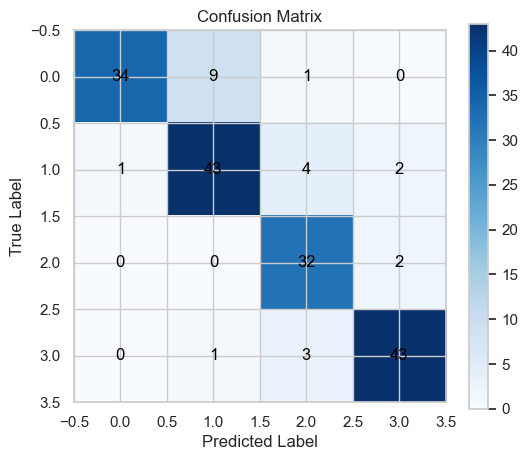

In [15]:
# ==============================
# Step 4: Report 模型评估
# ==============================

macro_f1 = f1_score(y_test, y_pred, average="macro")
print("\n🎯 Macro-F1 Score:", round(macro_f1, 4))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# 可视化混淆矩阵
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1️⃣ 读取测试集
df_test = pd.read_csv("test.csv")

# 2️⃣ 对 depth 做 log1p
df_test['depth'] = np.log1p(df_test['depth'])

# 4️⃣ 缩放测试集的 depth 和 sig
df_test[['depth', 'sig']] = scaler.transform(df_test[['depth', 'sig']])

# 5️⃣ 准备测试集特征矩阵
X_new = df_test.drop(columns=["id"], errors="ignore").values

# 6️⃣ 使用已训练的模型预测
y_pred = knn.predict(X_new)

# 7️⃣ 保存预测结果
submission = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ 测试集预测完成，结果已保存为 submission.csv")
print(submission.head())


✅ 测试集预测完成，结果已保存为 submission.csv
       id  label
0  100001      2
1  100002      0
2  100003      0
3  100004      1
4  100005      0
